# Car price prediction

The used car sales service is developing an application to attract new clients. In this app, users can quickly find out the market value of their car. You have access to historical data: technical specifications, configurations, and car prices. You need to build a model to determine the car's price.

The customer values the following:

-prediction quality;

-prediction speed;

-training time.

In [1]:
!pip install phik
!pip install -U scikit-learn

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10, 8)

import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from scipy.stats import zscore
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyRegressor

import time

import phik
from sklearn.model_selection import train_test_split, GridSearchCV

## Data preparation

In [3]:
autos = pd.read_csv('/datasets/autos.csv', parse_dates=['DateCrawled', 'DateCreated', 'LastSeen'])

In [4]:
autos.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31,0,60437,2016-04-06 10:17:21



We will immediately filter out records with errors (database export date < registration year, ad creation date > export date).

In [5]:
autos = autos[autos['DateCrawled'].dt.year >= autos.RegistrationYear]
autos = autos[autos['DateCrawled'] >= autos['DateCreated']]

In [6]:
autos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 339839 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        339839 non-null  datetime64[ns]
 1   Price              339839 non-null  int64         
 2   VehicleType        316859 non-null  object        
 3   RegistrationYear   339839 non-null  int64         
 4   Gearbox            321873 non-null  object        
 5   Power              339839 non-null  int64         
 6   Model              322181 non-null  object        
 7   Kilometer          339839 non-null  int64         
 8   RegistrationMonth  339839 non-null  int64         
 9   FuelType           312538 non-null  object        
 10  Brand              339839 non-null  object        
 11  Repaired           274984 non-null  object        
 12  DateCreated        339839 non-null  datetime64[ns]
 13  NumberOfPictures   339839 non-null  int64   

### Removal of non-informative features.

For price prediction, neither the month of car registration nor information about the owner's address/activity matters. I would keep the information about the number of photos in the listing — this could potentially influence the buyer's decision to purchase the car at the listed price.

In [7]:
autos = autos.drop(['DateCrawled', 'DateCreated', 'PostalCode',
       'LastSeen', 'RegistrationMonth'], axis=1)

### Correlation analysis

In [8]:
autos.phik_matrix(interval_cols = ['Price', 'Power'])

/opt/conda/lib/python3.9/site-packages/phik/data_quality.py:82: UserWarning: Not enough unique value for variable NumberOfPictures for analysis 1. Dropping this column
  warnings.warn(


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
Price,1.000000,0.268160,0.687691,0.325259,0.005624,0.578856,0.323962,0.257157,0.356385,0.383108
VehicleType,0.268160,1.000000,0.278273,0.289225,0.011766,0.917258,0.189550,0.330173,0.633336,0.084338
RegistrationYear,0.687691,0.278273,1.000000,0.139250,0.000000,0.676274,0.638404,0.386917,0.420174,0.224264
Gearbox,0.325259,0.289225,0.139250,1.000000,0.010680,0.647755,0.021265,0.152485,0.522150,0.044657
Power,0.005624,0.011766,0.000000,0.010680,1.000000,0.000000,0.010755,0.011468,0.007633,0.010694
Model,0.578856,0.917258,0.676274,0.647755,0.000000,1.000000,0.440250,0.556286,0.998352,0.160278
Kilometer,0.323962,0.189550,0.638404,0.021265,0.010755,0.440250,1.000000,0.173412,0.285946,0.125711
FuelType,0.257157,0.330173,0.386917,0.152485,0.011468,0.556286,0.173412,1.000000,0.323578,0.044866
Brand,0.356385,0.633336,0.420174,0.522150,0.007633,0.998352,0.285946,0.323578,1.000000,0.106134
Repaired,0.383108,0.084338,0.224264,0.044657,0.010694,0.160278,0.125711,0.044866,0.106134,1.000000


It makes sense that the brand, model (and car type) are highly correlated (different brands usually don't give the same name to models). However, I wouldn't merge these variables into one or remove the brand — after all, just from the brand name alone, you can roughly estimate the price, and the specific model only refines it further.

### Anomaly detection

In [9]:
numeric_columns = ['Price', 'Kilometer', 'Power', 'NumberOfPictures', 'RegistrationYear']
categorial_columns = ['VehicleType', 'Gearbox', 'Model',
       'FuelType', 'Brand', 'Repaired']

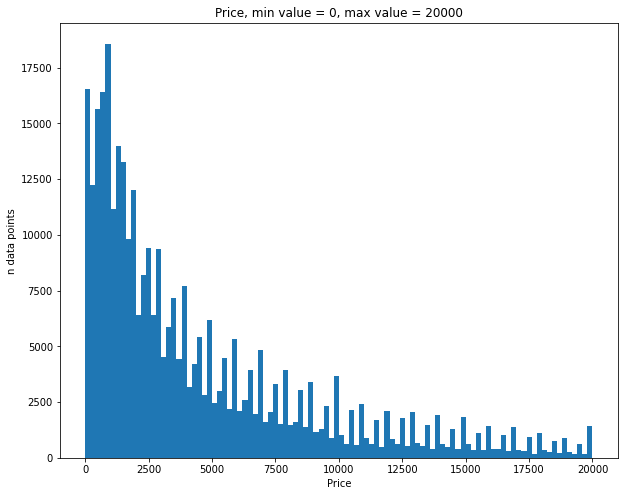

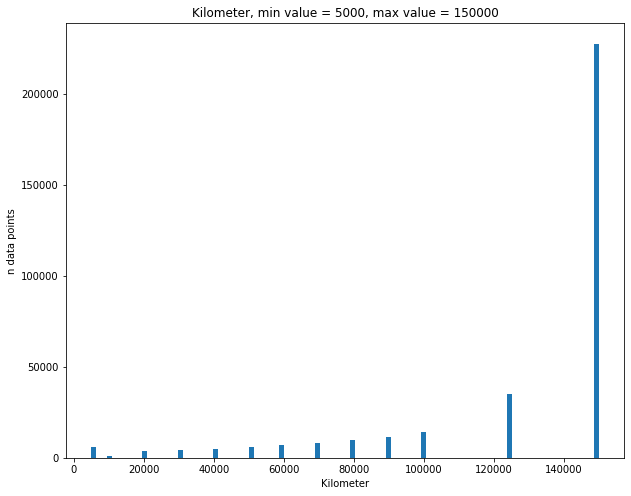

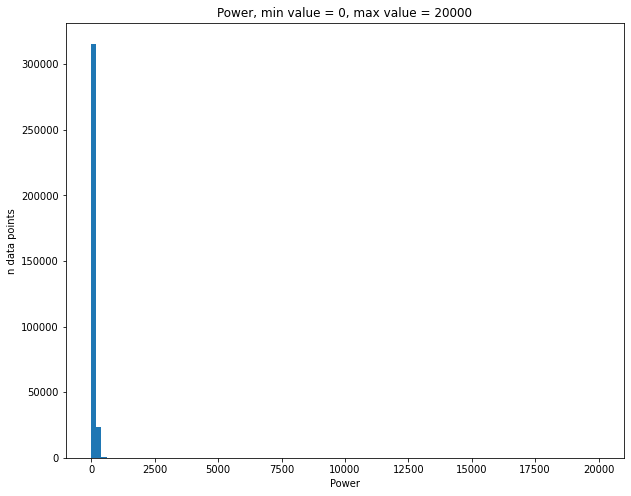

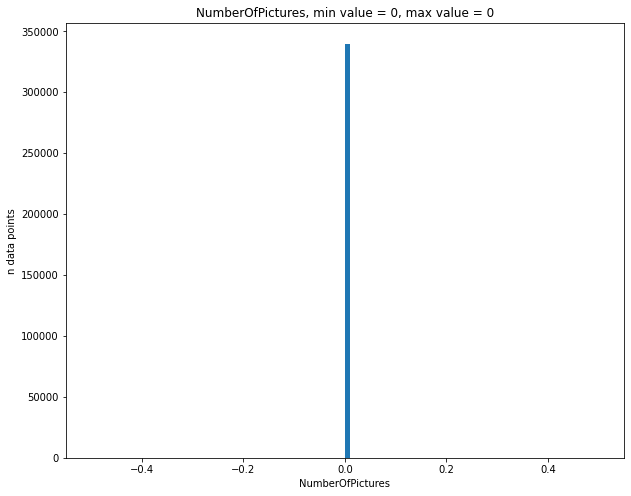

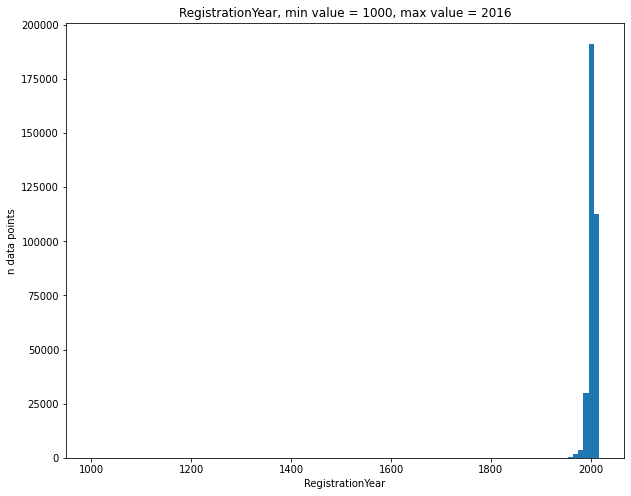

In [10]:
for i in numeric_columns:
    plt.hist(autos[i], bins=100)
    plt.ylabel('n data points')
    plt.xlabel(f'{i}')
    plt.title(f'{i}, min value = {autos[i].min()}, max value = {autos[i].max()}')
    plt.show()

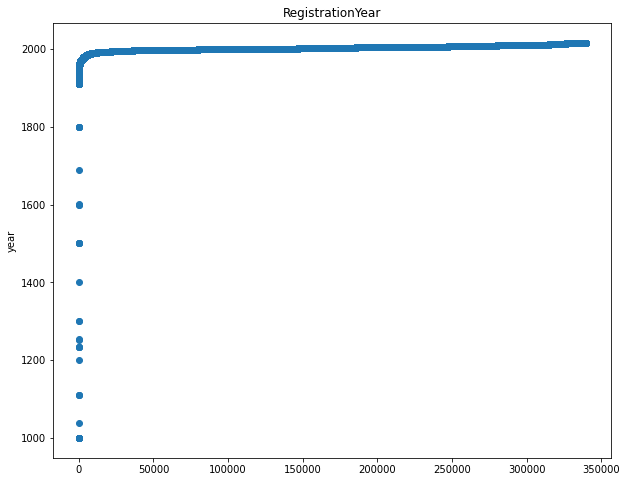

In [11]:
#Let's take a closer look at the anomaly charts – we'll simply sort the records by registration year and plot it.
plt.scatter(range(len(autos['RegistrationYear'])), autos['RegistrationYear'].sort_values())
plt.title('RegistrationYear')
plt.ylabel('year')
plt.show()

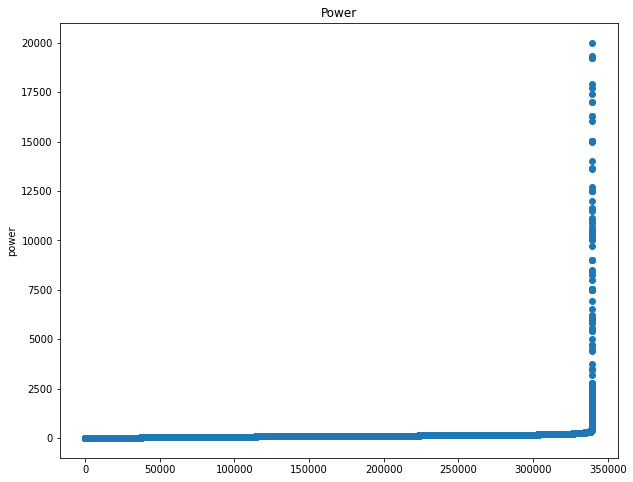

In [12]:
#same for engine power
plt.scatter(range(len(autos['Power'])), autos['Power'].sort_values())
plt.title('Power')
plt.ylabel('power')
plt.show()

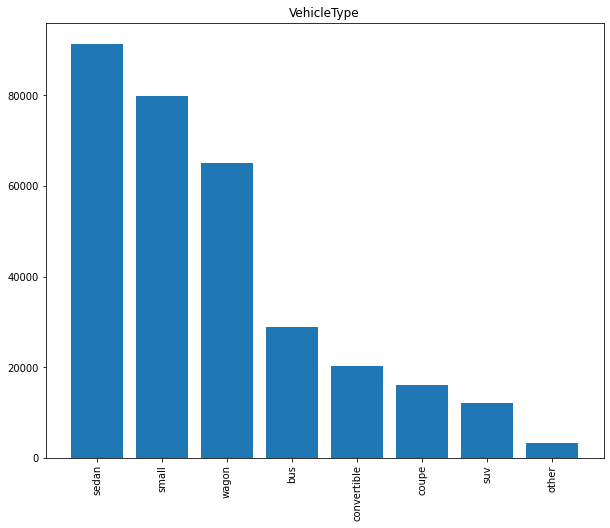

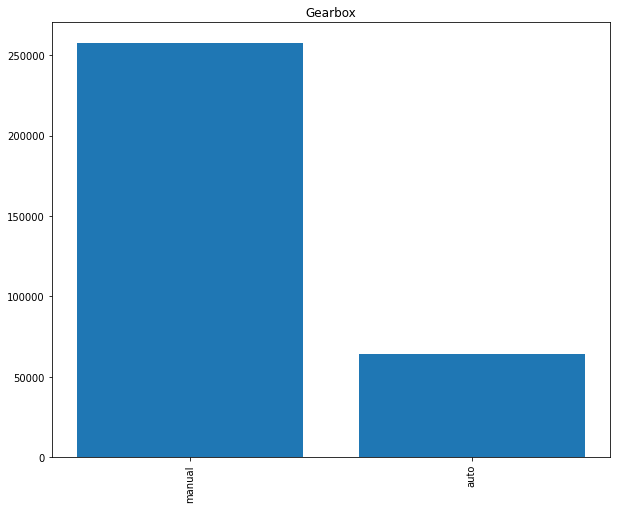

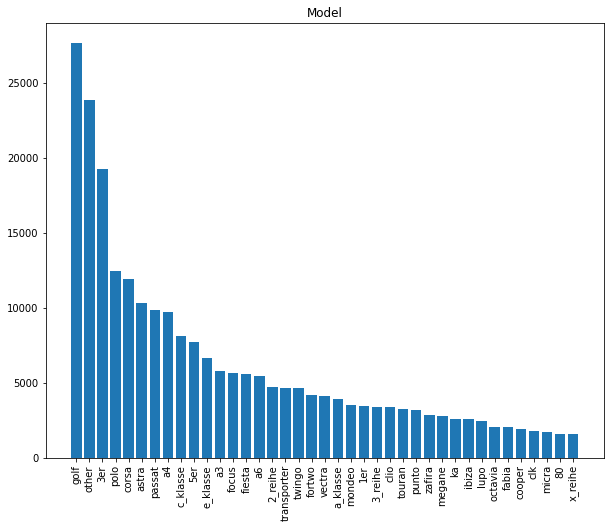

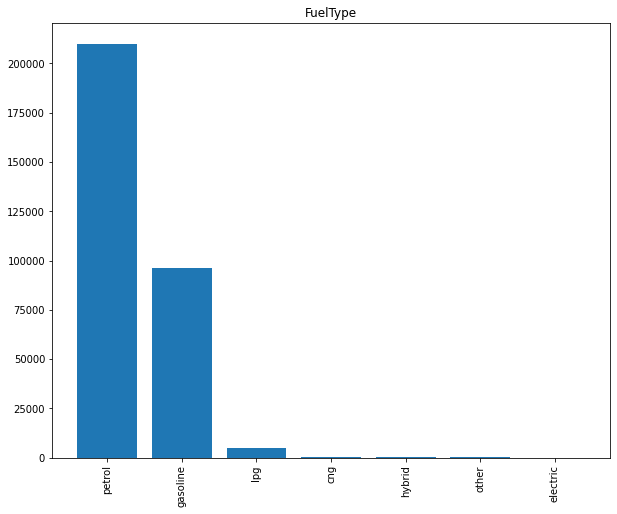

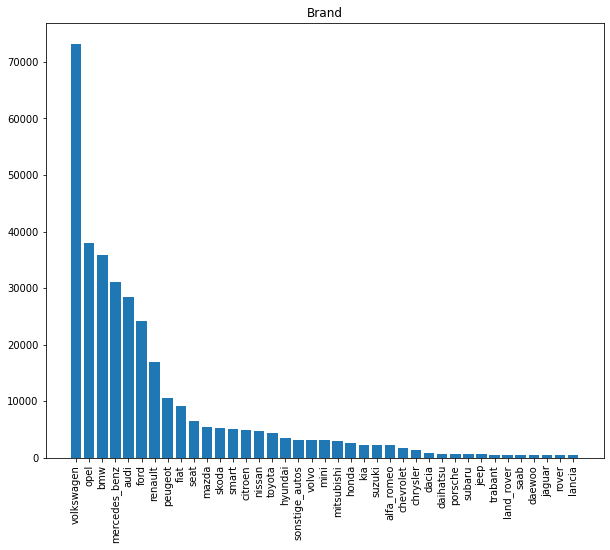

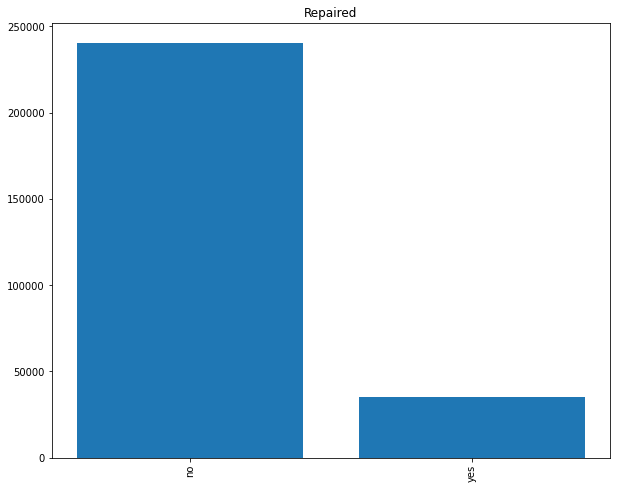

In [13]:
too_many_bars_thr = 40

for i in categorial_columns:
        thr = min(too_many_bars_thr, len(autos[i].unique()))
        plt.bar(range(1, thr), autos[i].value_counts()[:thr-1])
        plt.title(f'{i}')
        plt.xticks(range(1, thr), autos[i].value_counts()[:thr-1].index, rotation=90)
        plt.show() 

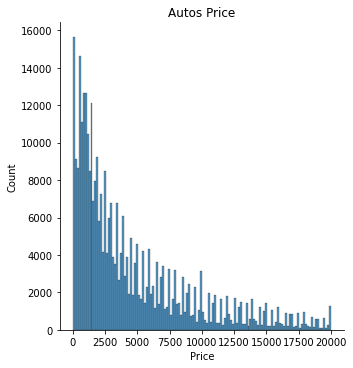

In [14]:
sns.displot(autos.Price)
plt.title('Autos Price')
plt.show()

We see that none of the listings contain photos, so we'll also remove this feature as uninformative.
We'll delete all records with a price ≤ 500.

There are also ambiguous data in the RegistrationYear column — there are cars from both the early Middle Ages and the future. These data will not be included in further analysis (we'll remove all cars registered before 1985 — vehicles from the future were already filtered out at the beginning).

Additionally, we'll delete all rows where engine power equals zero. The remaining outliers will be filtered using z-score.
Unfortunately, I couldn't wrap this into a complete transformer, so these operations will need to be done manually, even before splitting into train and test sets.

In [15]:
autos = autos.drop('NumberOfPictures', axis=1)

In [16]:
price_thr = 500
autos = autos[autos['Price'] > price_thr]

In [17]:
year_lower = 1985
autos = autos[(autos['RegistrationYear'] >= year_lower)]

In [18]:
autos = autos[(~autos['Model'].isna()) & (~autos['Brand'].isna())]

In [19]:
power_thr = 500

autos = autos[(autos['Power'] > 0) & (autos['Power'] < power_thr)]

Filtering suspiciously high/low engine power values using z-score: for each brand and model, I calculated the average engine power, manually verified that the resulting average is reasonable, and used it in the z-score formula.

In [20]:
# The average engine power for the groups looks reasonable.
autos.groupby(['Model', 'Brand'])['Power'].mean().sort_values()

Model               Brand     
601                 trabant        26.310078
kaefer              volkswagen     47.020000
arosa               seat           52.804598
seicento            fiat           53.168044
other               smart          54.434783
                                     ...    
911                 porsche       293.756098
range_rover_evoque  land_rover    296.000000
6er                 bmw           310.500000
cayenne             porsche       334.404762
m_reihe             bmw           341.270833
Name: Power, Length: 294, dtype: float64

In [21]:
zscore_thr = 3

idx_to_leave = []
for spec, df in autos.groupby(['Model', 'Brand']):
    mean = df['Power'].mean()
    std = df['Power'].std()
    zscore = np.abs((df['Power'] - mean)/std)
    idx_to_leave.extend(zscore[zscore < zscore_thr].index.tolist())

In [22]:
autos = autos.reindex(idx_to_leave)

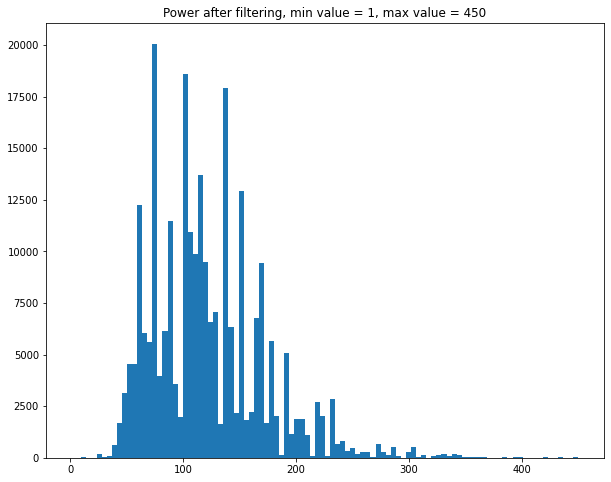

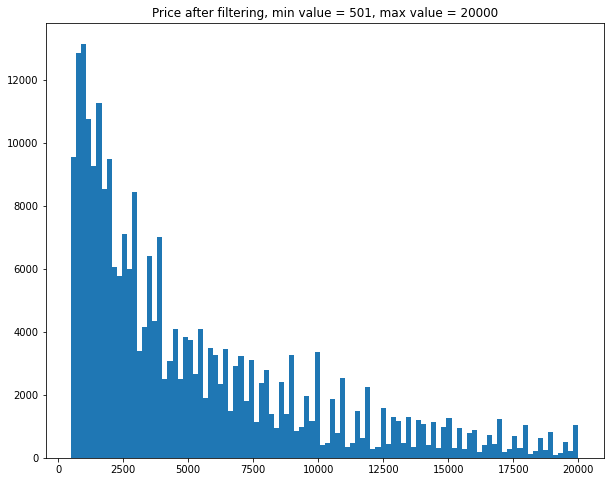

In [23]:
for i in ['Power', 'Price']:
    plt.hist(autos[i], bins=100)
    plt.title(f'{i} after filtering, min value = {autos[i].min()}, max value = {autos[i].max()}')
    plt.show()

In [24]:
train, test = train_test_split(autos, random_state=42, test_size=.25)

In [25]:
X_train = train.drop(['Price'], axis=1)
y_train = train['Price']

X_test = test.drop(['Price'], axis=1)
y_test = test['Price']

Final transformer:

In [26]:
numeric_columns = ['Kilometer', 'Power', 'RegistrationYear']
ordinal_columns = ['VehicleType', 'Gearbox', 'FuelType', 'Repaired', 'Brand', 'Model']

In [27]:
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

In [28]:
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
])

In [29]:
ordinal_transformer = Pipeline([('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan))])

In [30]:
preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numeric_columns),
    ('ord', ordinal_transformer, ordinal_columns)
], remainder='drop')

In [31]:
preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median'))]),
                                 ['Kilometer', 'Power', 'RegistrationYear']),
                                ('ord',
                                 Pipeline(steps=[('encoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=nan))]),
                                 ['VehicleType', 'Gearbox', 'FuelType',
                                  'Repaired', 'Brand', 'Model'])])

In [32]:
X_train_transformed = preprocessor.fit_transform(X_train)
X_train_transformed = pd.DataFrame(X_train_transformed, index = train.index, columns = preprocessor.get_feature_names_out()).astype(float)

In [33]:
X_test_transformed = preprocessor.transform(X_test)
X_test_transformed = pd.DataFrame(X_test_transformed, index = test.index, columns = preprocessor.get_feature_names_out()).astype(float)

## Model training

In [34]:
del autos
del X_train
del X_test
del train
del test

### LightGBM

In [35]:
model = LGBMRegressor(random_state = 42)

param_grid = {
    'learning_rate': [0.05, 0.2],
    'n_estimators': [50, 100],
}

grid_search_lg = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    scoring='neg_mean_squared_error', 
    cv=3, 
    verbose=2, 
    n_jobs=-1
)

grid_search_lg.fit(X_train_transformed, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END ................learning_rate=0.05, n_estimators=50; total time=   2.5s
[CV] END ................learning_rate=0.05, n_estimators=50; total time=   2.7s
[CV] END ................learning_rate=0.05, n_estimators=50; total time=   2.4s
[CV] END ...............learning_rate=0.05, n_estimators=100; total time=   5.2s
[CV] END ...............learning_rate=0.05, n_estimators=100; total time=   5.4s
[CV] END ...............learning_rate=0.05, n_estimators=100; total time=   5.0s
[CV] END .................learning_rate=0.2, n_estimators=50; total time=   2.4s
[CV] END .................learning_rate=0.2, n_estimators=50; total time=   2.6s
[CV] END .................learning_rate=0.2, n_estimators=50; total time=   2.3s
[CV] END ................learning_rate=0.2, n_estimators=100; total time=   4.1s
[CV] END ................learning_rate=0.2, n_estimators=100; total time=   4.3s
[CV] END ................learning_rate=0.2, n_est

GridSearchCV(cv=3, estimator=LGBMRegressor(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.2],
                         'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=2)

In [36]:
print(f'Lightgbm best rmse: {np.sqrt(-1*grid_search_lg.best_score_)}')

Lightgbm best rmse: 1546.8679108448214


In [37]:
grid_search_lg.best_estimator_

LGBMRegressor(learning_rate=0.2, random_state=42)

In [38]:
#training time estimation

start_time = time.time()
model = grid_search_lg.best_estimator_

model.fit(X_train_transformed, y_train)
train_time = time.time()
model.predict(X_train_transformed)
pred_time = time.time()

In [39]:
print(f'''Lightgbm training time: {(train_time - start_time)/60} min\n
Lightgbm prediction time: {(pred_time - train_time)/60} min''')

Lightgbm training time: 0.08390659093856812 min

Lightgbm prediction time: 0.020069320996602375 min


### Random forest

In [40]:
model = RandomForestRegressor(random_state = 42)


param_grid = {
    'max_depth': [3, 5],
    'n_estimators': [50, 60],
}

grid_search_rf = GridSearchCV(
    estimator=model, 
    param_grid=param_grid, 
    scoring='neg_mean_squared_error', 
    cv=3, 
    verbose=2, 
    n_jobs=-1
)

grid_search_rf.fit(X_train_transformed, y_train)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END .......................max_depth=3, n_estimators=50; total time=   3.1s
[CV] END .......................max_depth=3, n_estimators=50; total time=   3.0s
[CV] END .......................max_depth=3, n_estimators=50; total time=   3.1s
[CV] END .......................max_depth=3, n_estimators=60; total time=   3.8s
[CV] END .......................max_depth=3, n_estimators=60; total time=   3.9s
[CV] END .......................max_depth=3, n_estimators=60; total time=   3.7s
[CV] END .......................max_depth=5, n_estimators=50; total time=   5.2s
[CV] END .......................max_depth=5, n_estimators=50; total time=   5.1s
[CV] END .......................max_depth=5, n_estimators=50; total time=   4.8s
[CV] END .......................max_depth=5, n_estimators=60; total time=   5.7s
[CV] END .......................max_depth=5, n_estimators=60; total time=   5.8s
[CV] END .......................max_depth=5, n_es

GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [3, 5], 'n_estimators': [50, 60]},
             scoring='neg_mean_squared_error', verbose=2)

In [41]:
print(f'Random Forest best rmse: {np.sqrt(-1*grid_search_rf.best_score_)}')

Random Forest best rmse: 2291.1046085539992


In [42]:
#training time estimatioin

start_time = time.time()
model = grid_search_rf.best_estimator_

model.fit(X_train_transformed, y_train)
train_time = time.time()
model.predict(X_train_transformed)
pred_time = time.time()

In [43]:
print(f'''Random Forest training time: {(train_time - start_time)/60} min\n
Random Forest prediction time: {(pred_time - train_time)/60} min''')

Random Forest training time: 0.12346815665562948 min

Random Forest prediction time: 0.005691047509511312 min


## Model analysis

The random forest model demonstrated significantly better prediction time (less than a minute).

In terms of performance and training time, LGBM clearly wins — we'll take this model as the best. Let's obtain the values on the test set:

In [44]:
y_pred = grid_search_lg.predict(X_test_transformed)

print(f'rmse on test samples for the best estimator: {np.sqrt(mean_squared_error(y_test, y_pred))}')

rmse on test samples for the best estimator: 1535.4483786537394


The necessary condition (RMSE < 2500) is also met on the test set.

Let's compare the predictions of the best model with those of the DummyRegressor.

In [45]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(X_train_transformed, y_train)
y_pred_dummy = dummy_regr.predict(X_test_transformed)

In [46]:
print(f'rmse on test samples for the dummy estimator: {np.sqrt(mean_squared_error(y_test, y_pred_dummy))}')

rmse on test samples for the dummy estimator: 4539.8092458149795


Conclusions: The following steps were taken:

The input data was analyzed — a sanity check was conducted, missing values were filled, and columns that do not contribute meaningfully to the task were filtered out.

Two car price prediction models were built. Among them, the best one was chosen based on RMSE and prediction time.

The quality of the model was checked on test data. The RMSE metric on the test data does not exceed the specified threshold.

A comparison was made between the best model and the DummyRegressor. As a result, we found that our model's performance on the test set was better than that of the constant model.